<a item='header'></a>

# Bayesian Neural Networks

This tutorial is an introduction to Bayesian methods in Neural Networks, and should be a gentle introduction to Bayesian inference methods and probabilistic modeling. Prior knowledge of basic probability theory is recommended, although not strictly required. 

As for the code in this notebook, the primary python library used to model BNNs is [Edward](http://edwardlib.org), a tensorflow library that allows probablistic modeling and Bayesian modeling. Make sure tensorflow, numpy, edward, as well as matplotlib, is properly installed before using this notebook.  
  
_(Note:Make sure to use tensorflow 1.5 or a "core dump: illegal instruction" error may occur when importing edward)_

Many thanks are given to Professor Andrew Wilson, who has both introduced and helped us understand many of the concepts written here.

In [1]:
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Another Note/warning: The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

<a item='TOC'></a>
## Table of contents

### [1. Bayesian Linear Regression](#Bayesian Linear Regression)

1.1 [problem setup: simple linear regression](#BLR1)

1.2 [Introduction to Bayesian Inference](#BLR2)

1.3 [Implementing Bayesian Linear Regression](#BLR3)

### [2. Approximate Inference](#ApproxInf)
2.1 Variational Inference

2.2 Markov Chain - Monte Carlo (MCMC) 

### [3. Bayesian Neural Network Example__](#BNN)
    



<a id='Bayesian Linear Regression'></a>

## 1. Bayesian Linear Regression

<a id='BLR1'></a>

### 1.1 Problem setup: simple linear regression
Let's first tackle simple linear regression. Simple linear regression is a regression model that models an unknown relationship between two scalar entities (denoted as $x$ and $y$) as a linear relationship such that $y_i$, an ith sample of $y$, can be written as $y_i = \beta x_i + \epsilon$.
More concretely, the linear regression problem is the following:

Given a dataset D with N data points:

$$ D = \{(x_i, y_i)\}_{i=1}^{N}$$ 

where x_i is the feature input for the ith data point and y the corresponding target value for the ith data point, find $\beta$ that minimizes the following objective:  

$$ \sum_i^N (y_i - \beta x_i)^2 $$  

This formulation commonly known as the __least squares problem__. What is also important is that the least-squares problem is mathematically equivalent to assuming the residual $y_i - \beta x_i$, corresponding to the noise term $\epsilon$, to be a _Gaussian white noise_. This noise has a mean at $\mu = 0 $  with variance $\sigma^2$, for all values of $i \in N$. Linear regression therefore also treats $y$ as a Gaussian random variable, centered about $\beta x$ and with variance $\sigma^2$. We can represent this information with the following notation:
$$ y \sim Normal(\beta x, \sigma^2)$$

To see how the least squares is equivalent to an assumption of Gaussian white noise, one looks at the __likelihood__ function for the Gaussian. Given the above expression of y, the likelihood function, a function that evaluates the probability of a given sample given our assumptions of the underlying mechanics, can be written as: 

$$ \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma^2} } exp(\frac{-(y_i - \beta x_i)^2}{\sigma^2} )$$

Maximizing this likelihood function is equivalent to minimizing the negative log of it, since $x$ and $\log x$ always increases/decreases together. When taking the negative log of this likelihood function, we obtain the least-squares formulation, showing the implicit normality assumption in least-squares regression.

Solving optimization problems like the one presented above is an example of a __Maximum Likelihood Estimation(MLE)__ approach, or more generally speaking, a _frequentist_ approach. Frequentist approaches assume that there is enough data to conclude statistically significant conclusions about $\beta$ given the dataset, and produce a single point solution for $\beta$. This is often the approach taken for many conventional and widely adopted machine learning practices, but can be prone to overfitting when dataset is relatively small, or with increased complexity of the loss/likelihood functions - as is the case for neural networks - suffer from lack of interpretability.

<a id='BLR2'></a>

### 1.2 Introduction to Bayesian Inference

_Bayesian_ approaches, on the other hand, avoid point estimations entirely. Rather, Bayesian method represent learned parameters - in the case for linear regression, the parameter $\beta$ - as probability distributions rather than single optimal solutions.  This works well for many statistical modeling scenarios, where data insufficiently represents true relationships and functions due to noise or incorrect data, and thus may require us to represent _uncertainty_ in learned parameters. 

This information on parameter uncertainties also provides prediction uncertainties, and can be incredibly useful for fields like deep learning, where model uncertainty has traditionally been poorly understood due to complexity of neural networks.


At the core of Bayesian methods lies the famous Bayes' Theorem, which can be written - in a more applicable form for probabilistic modeling - as the following:<br><br>

$$ P(Parameters \mid Data,Model) = \frac{P(Data \mid Parameters, Model) \cdot P(Parameters\mid Model)}{P(Data,Model)} $$
<br>
<br>
What makes Bayesian methods different is the addition of _prior belief_ to their models on the parameter being learned, which is represented as the second term on the numerator on the above expression as $P(Parameters \mid Model)$. When size of collected samples used to train statistical model is small, this prior will have relatively significant influence on the behavior of the models, but with growing size of dataset diminish in its effects.

The left side of this equation is what we aim to learn from the data, and what is called the _posterior distribution_ over the parameters, reflecting our beliefs on the parameter __after__ data has been observed. This posterior distribution can be further expanded as shown below:

_Note: model and parameters all represented as $\theta$ and data as D_
<br><br><br>
$$ Posterior \hspace{1cm}\iff\hspace{1cm}P(\theta \mid D) = \frac{P(D \mid \theta) \cdot P(\theta)}{
 P(D)} \hspace{1cm}\iff\hspace{1cm} P(\theta\mid D) = \frac{P(D \mid \theta) \cdot P(\theta)}{
\int P(D \mid \theta) \cdot P(\theta)\hspace{0.1cm}d\theta}$$
<br><br>
Notice that the first term on the numerator, $P(D \mid \theta)$ corresponds to the _likelihood_. Second term on the numerator is the prior density over the parameters, as explained above. What is interesting is the denominator. The conversion of $P(D)$ into the integral is  the sum rule and the product rule of Bayes' Theorem, which respectively states that <br><br>
$$P(x) \iff \int_{-\infty}^\infty{P(x \cap y)\hspace{0.1cm}dy} \hspace{3cm}P(x,y)\iff P(x\mid y)\cdot p(y)$$

The first one is called the sum rule because integrals are essentially summations, and is particularly important in Bayesian statistics because it allows functions with multiple unknown random variables to collapse to functions with less parameters, known as _marginal probability densities_. Here, the denominator for the posterior corresponds to a quantity called the _marginal likelihood_, where model parameters has been marginalized out using the sum rule. Therefore the above expression is also written as<br><br>
$$ Posterior \iff \frac{Likelihood \cdot Prior}{Marginal\hspace{0.1cm}Likelihood} $$
<br>
  
The process of evaluating this expression, hence learning the parameters of a proposed statistical model, is called __inference__, and is the most important part of Bayesian modeling. What is particularly noteworthy is that if the integral for the marginal likelihood is solvable, the posterior distribution can be directly calculated without any estimations. The difficulty in Bayesian methods arise from models where the marginal likelihood cannot be directly evaluated, as will be fully explained in [section 2](#ApproxInf)


<a id='BLR3'></a>
### 1.3  Implementing Bayesian Linear Regression with Edward
Now that we have an idea of how Bayesian methods work, let's set up this inference model for simple linear regression to understand how we can implement inference with Edward. To do so, we simply need to set up the data, the likelihood function and set a prior distribution that represents prior beliefs.

__Data__:  
The dataset will be a generated dataset, obtained by the following data-generating function:
```python
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
def toy_dataset(dataset_size, true_beta, noise_stdev):
    # an array of randomly sampled integers
    x = np.random.uniform(low=1, high = 20, size=dataset_size)
    # target variable y is first initialized to true_beta * x
    y = x * true_beta
    # noise is a random normal with zero mean and stdev
    noise = np.random.normal(scale = noise_stdev,size = dataset_size)
    y += noise
    return x,y
```

This dataset-generating function returns a uniformly sampled x, and y, which is the result of multiplying x by a constant and adding Gaussian noise. We then train test split a generated dataset with this code:
```python
# split data into train and test set
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(sample_data_x, sample_data_y, test_size = .2)
```
A plot of a sample dataset made by this function is shown below:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
def toy_dataset(dataset_size, true_beta, noise_stdev):
    # an array of randomly sampled integers
    x = np.random.uniform(low=1, high = 20, size=dataset_size)
    
    # target variable y 
    y = x * true_beta
    
    # noise is a random normal with zero mean and stdev
    noise = np.random.normal(scale = noise_stdev,size = dataset_size)
    y += noise
    
    return x,y,true_beta, dataset_size

sample_data_x, sample_data_y, true_beta,dataset_size = toy_dataset(2000,10,50)

# split data into train and test set
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(sample_data_x, sample_data_y, test_size = .2)

#plot the sample_data
fig = plt.figure(figsize=(11,9))
plt.scatter(sample_data_x,sample_data_y, c="black")
plt.title("Sample Data Scatterplot with true beta="+str(true_beta),fontsize=20)
plt.xlabel("x", fontsize=25)
plt.ylabel("y",fontsize=25)
plt.show()

<Figure size 1100x900 with 1 Axes>

__Likelihood__:   
In the simple linear regression setting, for a given value of $\beta$, the likelihood of the data can be evaluated the following two ways:  
If we use the likelihood of a Gaussian, we use $ \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma^2} } exp(\frac{-(y_i - \beta x_i)^2}{\sigma^2} )$ and use some arbirary value of $\sigma^2$ 
<br> 

  
or using the equivalence of minimizing least squares with maximizing the likelihood of a Gaussian, we can also use $ -\sum_i^N (y_i - \beta x_i)^2 $  <br><br>

__Prior__:   
For this example, let's represent prior assumptions as a Gaussian with variance of 1 that is centered on a value that is different compared to the true $\beta$

We deliberately impose inaccurate prior beliefs, since this is more realistic, and will be illustrate the effectiveness of Bayesian methods even with incorrect priors. Also, keep in mind that if priors were really good and the parameter precisely known, there would be no need to do inference, or for that matter, model-based learning! 

<br>
Now we will actually implement this setup on Edward, as is illustrated in the code blocks shown below:<br><br>

```python
# Bayesian Linear Regression implementation in Edward
import tensorflow as tf
import edward as ed
from edward.models import Normal
import numpy as np
```
<br>
Remember to have all of these libraries installed. Here we import Normal. However, there are many types of random variables (any probability distribution you can think of is most likely in there) supported by Edward, so feel free to play around with these. We will learn in the next section that there are only certain types of random variables that allow exact Bayesian inference. However, Edward is aimed to do approximate inference, and thus can support a much wider variety of random variables.<br><br>

```python
# defining the tensor that will hold the feature input
X = tf.placeholder(tf.float32, shape=dataset_size)

# beta will have inaccurate prior initializations since prior is a relatively narrow Gaussian on the wrong integer
beta = Normal(loc=tf.constant(true_beta-5.0,shape=[1]),scale=tf.constant(100.0, shape=[1]))
y = Normal(loc=X*beta, scale=tf.ones(dataset_size))

# define the posterior
qbeta = Normal(loc=tf.get_variable("qbeta/loc", 1),
            scale=tf.nn.softplus(tf.get_variable("qbeta/scale", 1)))

```
<br>
The model used to instantiate the posterior determines the functional form of the _prior distribution_, which is the Gaussian/Normal distribution here. The loc, scale arguments each correspond to the mean $\mu$ and standard deviation $\sigma$ (and not the variance!) and can either be assigned manually as is done here or through some learned metafeatures derived from the data.<br><br>

```Python
# inference through minimizing the KL-divergence 
inference = ed.KLqp({beta:qbeta}, data ={X: train_x, y: train_y})
inference.run(n_samples=5, n_iter=1000)
inference.finalize()
```
<br>
Inference done here however, that although exact inference is possible when the prior is normal, as is the likelihood given the model, this code actually runs approximate inference. Edward is __not__ a library that does exact inference. This is not a setback. In fact, most frequent use cases of inference, as will be explained in the next section, will require approximate inference.

```python
# sample from the posterior and visualize
fig = plt.figure(figsize=(11,9))
post = qbeta.sample(100000).eval()
plt.hist(post, bins = 500,normed=True)
plt.show()
```

 Shown below is the result of visualizing the posterior - through a normalized histogram constructed from samples - obtained by training the Bayesian Linear regression model.

1000/1000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: 2113581.500


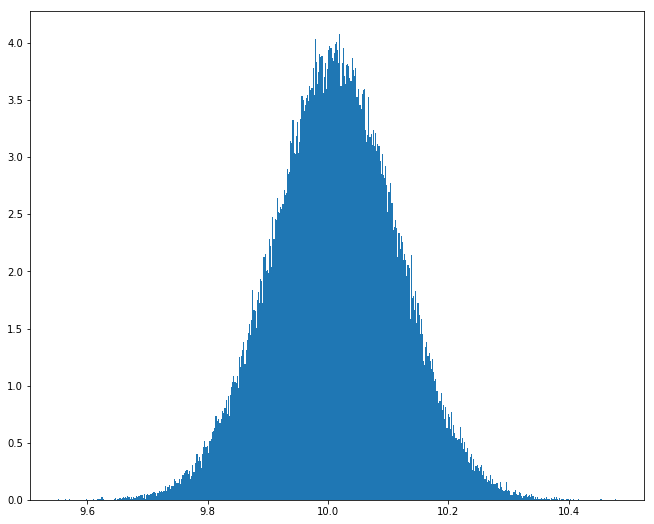

In [3]:
# Bayesian Linear Regression implementation in Edward
import tensorflow as tf
import edward as ed
from edward.models import Normal
import numpy as np

train_features = tf.placeholder(tf.float32, shape=train_x.shape)

# beta will have inaccurate prior initializations since prior is a relatively narrow Gaussian on the wrong integer
beta = Normal(loc=tf.constant(true_beta-5.0,shape=[1]),scale=tf.constant(1.0, shape=[1]))
target = Normal(loc=train_features*beta, scale=tf.ones(train_y.shape))

# define the posterior
qbeta = Normal(loc=tf.get_variable("qbeta/loc", 1),
            scale=tf.nn.softplus(tf.get_variable("qbeta/scale", 1)))

# inference through minimizing the KL-divergence 
inference = ed.KLqp({beta:qbeta}, data ={train_features: train_x, target: train_y})
inference.run(n_samples=5, n_iter=1000)
inference.finalize()


# sample from the posterior and visualize
fig = plt.figure(figsize=(11,9))
post = qbeta.sample(100000).eval()
plt.hist(post, bins = 500,normed=True)
plt.show()

In [27]:
qbeta.parameters

{'name': 'Normal_2/',
 'allow_nan_stats': True,
 'validate_args': False,
 'scale': <tf.Tensor 'Softplus:0' shape=(1,) dtype=float32>,
 'loc': <tf.Variable 'qbeta/loc:0' shape=(1,) dtype=float32_ref>}

This shows that the inaccurate prior - centered at 5 with a fairly small standard deviation of 1 - does not cripple Bayesian methods at all, and that inferred posterior does a very good job approximating the true beta value. Let's compare to a point estimate of the true $\beta$ value obtained by running sklearn's linear regression module. Since our posterior distribution is a Gaussian, the point estimate and the peak of the inferred posterior above should be roughly the same. The code block used is as follows:

```python
from sklearn.linear_model import LinearRegression

lm = LinearRegression(fit_intercept=False)
lm.fit(sample_data_x.reshape(-1,1), sample_data_y.reshape(-1,1))
print(float(lm.coef_))
```

MLE estmate of true beta is: 10.014182476359126


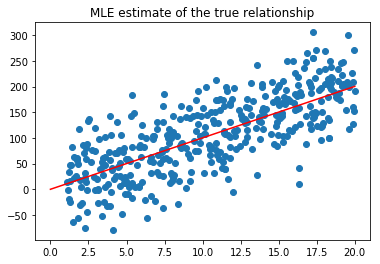

In [10]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression(fit_intercept=False)
lm.fit(train_x.reshape(-1,1), train_y.reshape(-1,1))
print("MLE estmate of true beta is: "+str(float(lm.coef_)))

plt.scatter(test_x, test_y,)
temp = np.linspace(0,20,100)
plt.plot(temp, lm.coef_*temp.reshape(-1,1), c='red')
plt.title("MLE estimate of the true relationship")
plt.show()

This should illustrate that inference is a comparable technique to MLE techniques. Let's see how well it does in terms of prediction accuracy. The way you do it is to first construct a predictive distribution from the posterior distribution. The prediction distribution can be obtained as the following:

As explained in the [1.1 Problem setup: Simple Linear Regression](#BLR1), linear regression assumes $ y \sim Normal(\beta x, \sigma^2)$. Note, however, that this assumes a deterministic $\beta$ 

```python 
# first contruct the predictive distribution based on the inferred posterior distribution
test_features = tf.placeholder(tf.float32, shape=test_x.shape)
y_pred = Normal(loc=test_features * qbeta, scale=tf.ones(test_y.shape))
```


```python
print("Mean squared error on test data for Bayesian model:")
print(ed.evaluate('mean_squared_error', data={test_features: test_x, y_pred:test_y}))

```

In [24]:
# first contruct the predictive distribution based on the inferred posterior distribution
test_features = tf.placeholder(tf.float32, shape=test_x.shape)
y_pred = Normal(loc=test_features * qbeta, scale=tf.ones(test_y.shape))

print("Mean squared error on test data for Bayesian model:")
print(ed.evaluate('mean_squared_error', data={test_features: test_x, y_pred:test_y}))

# prediction accuracy for sklearn's linear regression module
from sklearn.metrics import mean_squared_error

lm_pred = lm.predict(test_x.reshape(-1,1))

print("\n"+"Mean squared error on test data for MLE model:")
print(mean_squared_error(test_y.reshape(-1,1), lm_pred))

Mean squared error on test data for Bayesian model:
2507.1155

Mean squared error on test data for MLE model:
2507.208734894322


<a id='ApproxInf'></a>

## 2. Approximate Bayesian Inference

